In [2]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import scipy
import scipy.cluster.hierarchy as sch
import time
import seaborn

In [3]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

r = robjects.r
rpy2.robjects.numpy2ri.activate()

#importr("data.table")

newfunc = r.source("libClusteringGiadaMarsiliFast.R")
aggregateClusters=robjects.globalenv["aggregateClusters"]

R[write to console]: data.table 1.14.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: **********
This installation of data.table has not detected OpenMP support. It should still work but in single-threaded mode.
This is a Mac. Please read https://mac.r-project.org/openmp/. Please engage with Apple and ask them for support. Check r-datatable.com for updates, and our Mac instructions here: https://github.com/Rdatatable/data.table/wiki/Installation. After several years of many reports of installation problems on Mac, it's time to gingerly point out that there have been no similar problems on Windows or Linux.
**********



In [193]:
def stability_of_assets(df,companyticker,clustering_method):
    '''
    function to see how stable the assets are for a specific clustering method
    '''
    iterator = 10
    temp = np.zeros(shape = [np.shape(df)[1],1])
    if clustering_method == 'MLE':
        iterator = 1

    for j in range(iterator):
        if clustering_method == 'Louvain':
            df_clustered = LouvainCorrelationClustering(df)
        elif clustering_method == 'MLE':
            df_clustered = aggregateClusters_(df)
        df_clustered = df_clustered.sort_index()

        for i in range(len(df_clustered)):
            
            if df_clustered.iloc[i,0] == int(df_clustered[df_clustered.index == companyticker].Cluster):
                temp[i] = temp[i]+1

    how_often_same_cluster = temp/(j+1)

    return how_often_same_cluster


def aggregateClusters_(R,aggregateClusters=aggregateClusters):
    """Slight modification to the original function taken from "libClusteringGiadaMarsiliFast.R" package.
    The modification is made in order to simplify the use and to produce the output with the same format as
    the previous clustering method"""
    C = R.corr()
    intermediate_result = aggregateClusters(C.values)
    nb_clusters = len(intermediate_result[3])
    ls_dfs = []
    for i in range(nb_clusters):
        df = pd.DataFrame(np.array(intermediate_result[3][i]),columns = ['StockName'])
        df['Cluster'] = i
        ls_dfs.append(df)
    df = pd.concat(ls_dfs,ignore_index=True)
    dict_N_to_Stockname = dict(zip(range(1,len(list(R.columns))+1), R.columns))
    df['StockName'] = df['StockName'].apply(lambda number: dict_N_to_Stockname[number])
    
    df = df.reset_index()
    df = df.drop(columns = 'index')
    df = df.set_index('StockName')

    return df



def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)
    
    # TO CHECK: WHY N-1?!?!? isn't range enough to stop at N-1?!
    # _s stands for _structure below: 
    for i in range(N-1):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    

def LouvainCorrelationClustering(R):   # R is a matrix of return
    
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
      
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)
    DF=pd.DataFrame.from_dict(partition,orient="index")
    DF['StockName'] = R.columns
    DF = DF.reset_index()
    DF = DF.drop(columns = 'index')
    DF = DF.rename({0: 'Cluster'},axis = 'columns')
    DF = DF.set_index('StockName')
    
    return(DF)

def plot_corr(df,size=10,savefigure = False):
    '''Plot a graphical correlation matrix for a dataframe.
    code from:
    https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    plt.savefig('correlations_ordered.pdf')

def drop_nans(df,limit = 0.5):
    """given a dataframe and a limit value, first drops all the columns that have
    more than limit % nans than drops all raws containing at least one nan value"""
    row_num = df.shape[0]
    nan_col = df.isnull().sum(axis=0)>(row_num*limit)
    df=df.drop(columns=df.columns[nan_col])
    return df.dropna()

def pick_n_from_k(df,n,seed = 0,onlynames = False):
    """given a dataframe and a number N, returns a dataframe that 
    contains n randomly selected columns of the input dataframe"""
    
    k = df.shape[0]
    
    #safety check
    assert k >= n, 'K should be >= N'
    
    #if onlynames is active return only the name of the columns
    if onlynames:
        random.seed(seed)
        return random.sample(list(df.columns), n)
    return df.sample(n=n, random_state=seed, axis='columns')

def bootstrap_CI(data, nbr_draws):
    """Given an array and a number of random samples performs bootstrapping to
    find the confidence intervals of the mean"""
    # Input: your array and the number of random samples (e.g., 1000 is a good number)
    # Output: [lower error, upper error]

    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 0.5),np.nanpercentile(means, 99.5)]

def amount_and_time(df):
    '''
    function to calculate how much time it takes to runa the louvain and mle method respectively
    Calculates also how much clusters have been created
    '''
    amount_of_cluster_louv = []
    amount_of_cluster_agg = []
    time_louv = []
    time_agg = []

    for i in range(10):
        start_time = time.time()
        df_louvain = LouvainCorrelationClustering(df)
        time_louv.append(time.time()-start_time)
        amount_of_cluster_louv.append(max(df_louvain.Cluster))
        start_time = time.time()
        df_agg = aggregateClusters_(df)
        time_agg.append(time.time()-start_time)
        amount_of_cluster_agg.append(max(df_agg.Cluster))

    return amount_of_cluster_louv, time_louv, amount_of_cluster_agg, time_agg

In [238]:
saverfig = False

In [6]:
DF=pd.read_parquet("us_equities_logreturns.parquet")

DF_cut=DF.iloc[-5000:]

sel=DF_cut.isnull().sum(axis=0)>0
DF_cut=DF_cut.drop(columns=DF_cut.columns[sel])

Analyze the amount of clusters which are formed and the time it takes to do them

Change amount of assets

In [195]:
amount_of_cluster_louv, time_louv, amount_of_cluster_agg, time_agg = amount_and_time(DF_cut)
amount_of_cluster_louv_180, time_louv_180, amount_of_cluster_agg_180, time_agg_180 = amount_and_time(DF_cut.iloc[:,:180])
amount_of_cluster_louv_120, time_louv_120, amount_of_cluster_agg_120, time_agg_120 = amount_and_time(DF_cut.iloc[:,:120])
amount_of_cluster_louv_80, time_louv_80, amount_of_cluster_agg_80, time_agg_80 = amount_and_time(DF_cut.iloc[:,:80])
amount_of_cluster_louv_50, time_louv_50, amount_of_cluster_agg_50, time_agg_50 = amount_and_time(DF_cut.iloc[:,:50])

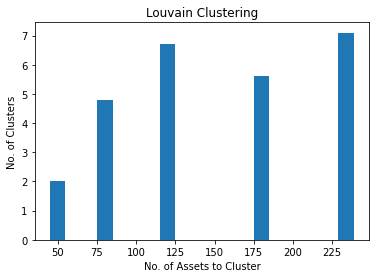

In [239]:
# how much clusters are formed on louvain
plt.bar(height = [np.asarray(amount_of_cluster_louv).mean(),np.asarray(amount_of_cluster_louv_180).mean(),np.asarray(amount_of_cluster_louv_120).mean(),np.asarray(amount_of_cluster_louv_80).mean(),np.asarray(amount_of_cluster_louv_50).mean()],x = [234,180,120,80,50],width = 10)
plt.xlabel('No. of Assets to Cluster')
plt.title('Louvain Clustering')
plt.ylabel('No. of Clusters')

if saverfig:
    plt.figure(dpi=300)
    plt.bar(height = [np.asarray(amount_of_cluster_louv).mean(),np.asarray(amount_of_cluster_louv_180).mean(),np.asarray(amount_of_cluster_louv_120).mean(),np.asarray(amount_of_cluster_louv_80).mean(),np.asarray(amount_of_cluster_louv_50).mean()],x = [234,180,120,80,50],width = 10)
    plt.xlabel('No. of Assets to Cluster')
    plt.title('Louvain Clustering')
    plt.ylabel('No. of Clusters')
    plt.savefig('amount_of_cluster_louv_no_of_assets.pdf')

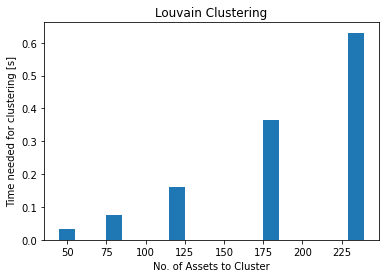

In [240]:
# how much clusters are formed on louvain
plt.bar(height = [np.asarray(time_louv).mean(),np.asarray(time_louv_180).mean(),np.asarray(time_louv_120).mean(),np.asarray(time_louv_80).mean(),np.asarray(time_louv_50).mean()],x = [234,180,120,80,50],width = 10)
plt.xlabel('No. of Assets to Cluster')
plt.title('Louvain Clustering')
plt.ylabel('Time needed for clustering [s]')

if saverfig:
    plt.figure(dpi=300)
    plt.bar(height = [np.asarray(time_louv).mean(),np.asarray(time_louv_180).mean(),np.asarray(time_louv_120).mean(),np.asarray(time_louv_80).mean(),np.asarray(time_louv_50).mean()],x = [234,180,120,80,50],width = 10)
    plt.xlabel('No. of Assets to Cluster')
    plt.title('Louvain Clustering')
    plt.ylabel('Time needed for clustering [s]')
    plt.savefig('amount_of_time_louv_no_of_assets.pdf')

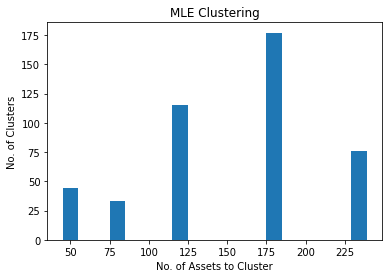

In [241]:
# how much clusters are formed on MLE
plt.bar(height = [np.asarray(amount_of_cluster_agg).mean(),np.asarray(amount_of_cluster_agg_180).mean(),np.asarray(amount_of_cluster_agg_120).mean(),np.asarray(amount_of_cluster_agg_80).mean(),np.asarray(amount_of_cluster_agg_50).mean()],x = [234,180,120,80,50],width = 10)
plt.xlabel('No. of Assets to Cluster')
plt.title('MLE Clustering')
plt.ylabel('No. of Clusters')

if saverfig:
    plt.figure(dpi=300)
    plt.bar(height = [np.asarray(amount_of_cluster_agg).mean(),np.asarray(amount_of_cluster_agg_180).mean(),np.asarray(amount_of_cluster_agg_120).mean(),np.asarray(amount_of_cluster_agg_80).mean(),np.asarray(amount_of_cluster_agg_50).mean()],x = [234,180,120,80,50],width = 10)
    plt.xlabel('No. of Assets to Cluster')
    plt.title('MLE Clustering')
    plt.ylabel('No. of Clusters')
    plt.savefig('amount_of_cluster_mle_no_of_assets.pdf')

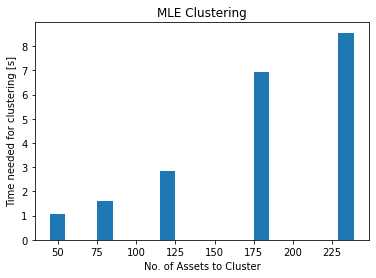

In [242]:
# how much time on MLE
plt.bar(height = [np.asarray(time_agg).mean(),np.asarray(time_agg_180).mean(),np.asarray(time_agg_120).mean(),np.asarray(time_agg_80).mean(),np.asarray(time_agg_50).mean()],x = [234,180,120,80,50],width = 10)
plt.xlabel('No. of Assets to Cluster')
plt.title('MLE Clustering')
plt.ylabel('Time needed for clustering [s]')

if saverfig:
    plt.figure(dpi=300)
    plt.bar(height = [np.asarray(time_agg).mean(),np.asarray(time_agg_180).mean(),np.asarray(time_agg_120).mean(),np.asarray(time_agg_80).mean(),np.asarray(time_agg_50).mean()],x = [234,180,120,80,50],width = 10)
    plt.xlabel('No. of Assets to Cluster')
    plt.title('MLE Clustering')
    plt.ylabel('Time needed for clustering [s]')
    plt.savefig('amount_of_time_mle_no_of_assets.pdf')
    

Change Amount of  Datapoints

In [200]:
amount_of_cluster_louv_4000, time_louv_4000, amount_of_cluster_agg_4000, time_agg_4000 = amount_and_time(DF_cut.iloc[:4000,:])
amount_of_cluster_louv_2000, time_louv_2000, amount_of_cluster_agg_2000, time_agg_2000 = amount_and_time(DF_cut.iloc[:2000,:])
amount_of_cluster_louv_1000, time_louv_1000, amount_of_cluster_agg_1000, time_agg_1000 = amount_and_time(DF_cut.iloc[:1000,:])
amount_of_cluster_louv_500, time_louv_500, amount_of_cluster_agg_500, time_agg_500 = amount_and_time(DF_cut.iloc[:500,:])

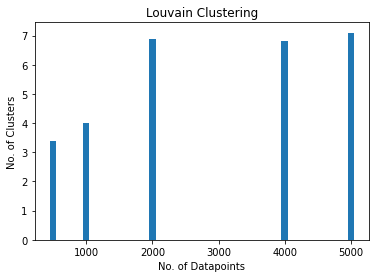

In [243]:
# how much clusters are formed on louvain
plt.bar(height = [np.asarray(amount_of_cluster_louv).mean(),np.asarray(amount_of_cluster_louv_4000).mean(),np.asarray(amount_of_cluster_louv_2000).mean(),np.asarray(amount_of_cluster_louv_1000).mean(),np.asarray(amount_of_cluster_louv_500).mean()],x = [5000,4000,2000,1000,500],width = 100)
plt.xlabel('No. of Datapoints')
plt.title('Louvain Clustering')
plt.ylabel('No. of Clusters')

if saverfig:
    plt.figure(dpi=300)
    plt.bar(height = [np.asarray(amount_of_cluster_louv).mean(),np.asarray(amount_of_cluster_louv_4000).mean(),np.asarray(amount_of_cluster_louv_2000).mean(),np.asarray(amount_of_cluster_louv_1000).mean(),np.asarray(amount_of_cluster_louv_500).mean()],x = [5000,4000,2000,1000,500],width = 100)    
    plt.xlabel('No. of Datapoints')
    plt.title('Louvain Clustering')
    plt.ylabel('No. of Clusters')
    plt.savefig('amount_of_cluster_louv_no_of_data.pdf')

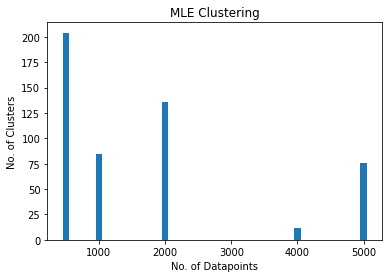

In [244]:
# how much clusters are formed on mle
plt.bar(height = [np.asarray(amount_of_cluster_agg).mean(),np.asarray(amount_of_cluster_agg_4000).mean(),np.asarray(amount_of_cluster_agg_2000).mean(),np.asarray(amount_of_cluster_agg_1000).mean(),np.asarray(amount_of_cluster_agg_500).mean()],x = [5000,4000,2000,1000,500],width = 100)
plt.xlabel('No. of Datapoints')
plt.title('MLE Clustering')
plt.ylabel('No. of Clusters')

if saverfig:
    plt.figure(dpi=300)
    plt.bar(height = [np.asarray(amount_of_cluster_agg).mean(),np.asarray(amount_of_cluster_agg_4000).mean(),np.asarray(amount_of_cluster_agg_2000).mean(),np.asarray(amount_of_cluster_agg_1000).mean(),np.asarray(amount_of_cluster_agg_500).mean()],x = [5000,4000,2000,1000,500],width = 100)
    plt.xlabel('No. of Datapoints')
    plt.title('MLE Clustering')
    plt.ylabel('No. of Clusters')
    plt.savefig('amount_of_cluster_agg_no_of_data.pdf')

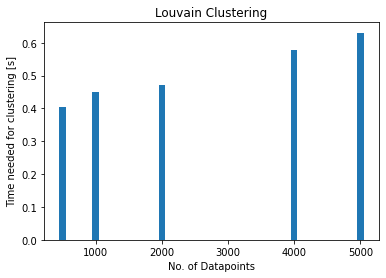

In [245]:
# how much time is needed for louvain
plt.bar(height = [np.asarray(time_louv).mean(),np.asarray(time_louv_4000).mean(),np.asarray(time_louv_2000).mean(),np.asarray(time_louv_1000).mean(),np.asarray(time_louv_500).mean()],x = [5000,4000,2000,1000,500],width = 100)
plt.xlabel('No. of Datapoints')
plt.title('Louvain Clustering')
plt.ylabel('Time needed for clustering [s]')

if saverfig:
    plt.figure(dpi=300)
    plt.bar(height = [np.asarray(time_louv).mean(),np.asarray(time_louv_4000).mean(),np.asarray(time_louv_2000).mean(),np.asarray(time_louv_1000).mean(),np.asarray(time_louv_500).mean()],x = [5000,4000,2000,1000,500],width = 100)
    plt.xlabel('No. of Datapoints')
    plt.title('Louvain Clustering')
    plt.ylabel('Time needed for clustering [s]')
    plt.savefig('time_for_cluster_louv_no_of_data.pdf')

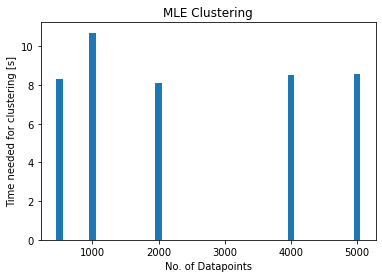

In [246]:
# how much time it takes mle
plt.bar(height = [np.asarray(time_agg).mean(),np.asarray(time_agg_4000).mean(),np.asarray(time_agg_2000).mean(),np.asarray(time_agg_1000).mean(),np.asarray(time_agg_500).mean()],x = [5000,4000,2000,1000,500],width = 100)
plt.xlabel('No. of Datapoints')
plt.title('MLE Clustering')
plt.ylabel('Time needed for clustering [s]')

if saverfig:
    plt.figure(dpi=300)
    plt.bar(height = [np.asarray(time_agg).mean(),np.asarray(time_agg_4000).mean(),np.asarray(time_agg_2000).mean(),np.asarray(time_agg_1000).mean(),np.asarray(time_agg_500).mean()],x = [5000,4000,2000,1000,500],width = 100)
    plt.xlabel('No. of Datapoints')
    plt.title('MLE Clustering')
    plt.ylabel('Time needed for clustering [s]')
    plt.savefig('time_for_cluster_mle_no_of_data.pdf')

No. of Assets in different classes

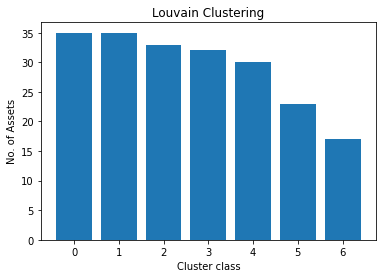

In [247]:
cluster_size_louv = []

df_louvain = LouvainCorrelationClustering(DF_cut)

for i in range(max(df_louvain.Cluster)):
    cluster_size_louv.append(np.size(df_louvain[df_louvain.Cluster == i]))

cluster_size_louv.sort(reverse = True)

plt.bar(height = (cluster_size_louv),x = range(max(df_louvain.Cluster)))
plt.title('Louvain Clustering')
plt.xlabel('Cluster class')
plt.ylabel('No. of Assets')

if saverfig:
    plt.figure(dpi = 300)
    plt.bar(height = (cluster_size_louv),x = range(max(df_louvain.Cluster)))
    plt.title('Louvain Clustering')
    plt.xlabel('Cluster class')
    plt.ylabel('No. of Assets')
    plt.savefig('how_many_asset_in_cluster_louvain.pdf')


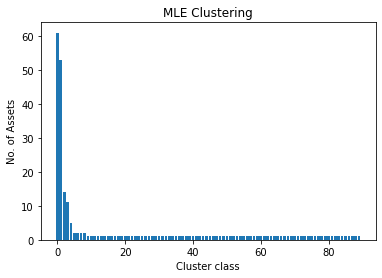

In [248]:
cluster_size_agg = []
df_agg = aggregateClusters_(DF_cut.iloc[4000:,:])

for i in range(max(df_agg.Cluster)):
    cluster_size_agg.append(np.size(df_agg[df_agg.Cluster == i]))

cluster_size_agg.sort(reverse = True)

plt.bar(height = (cluster_size_agg),x = range(max(df_agg.Cluster)))
plt.title('MLE Clustering')
plt.xlabel('Cluster class')
plt.ylabel('No. of Assets')

if saverfig:
    plt.figure(dpi = 300)
    plt.bar(height = (cluster_size_agg),x = range(max(df_agg.Cluster)))
    plt.title('MLE Clustering')
    plt.xlabel('Cluster class')
    plt.ylabel('No. of Assets')
    plt.savefig('how_many_asset_in_cluster_agg_full.pdf')

Stability of asset

In [19]:
GE_stability_louv = stability_of_assets(DF_cut,'GE','Louvain')
XOM_stability_louv = stability_of_assets(DF_cut,'XOM','Louvain')
JNJ_stability_louv = stability_of_assets(DF_cut,'JNJ','Louvain')
MCD_stability_louv = stability_of_assets(DF_cut,'MCD','Louvain')
GSPC_stability_louv = stability_of_assets(DF_cut,'^GSPC','Louvain')

In [211]:
GE_stability_agg = stability_of_assets(DF_cut,'GE','MLE')
XOM_stability__agg = stability_of_assets(DF_cut,'XOM','MLE')
JNJ_stability_agg = stability_of_assets(DF_cut,'JNJ','MLE')
MCD_stability_agg = stability_of_assets(DF_cut,'MCD','MLE')
GSPC_stability_agg = stability_of_assets(DF_cut,'^GSPC','MLE')

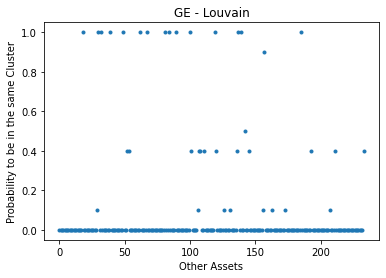

In [249]:
plt.plot(GE_stability_louv,'.')
plt.title('GE - Louvain')
plt.xlabel('Other Assets')
plt.ylabel('Probability to be in the same Cluster')


if saverfig:
    plt.figure(dpi = 300)
    plt.plot(GE_stability_louv,'.')
    plt.title('GE - Louvain')
    plt.xlabel('Other Assets')
    plt.ylabel('Probability to be in the same Cluster')
    plt.savefig('GE_Louvain_stability.pdf')


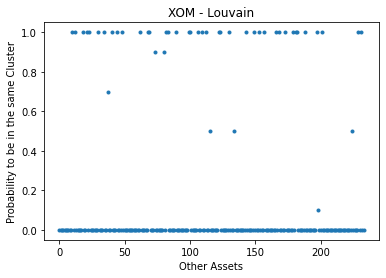

In [250]:
plt.plot(XOM_stability_louv,'.')
plt.title('XOM - Louvain')
plt.xlabel('Other Assets')
plt.ylabel('Probability to be in the same Cluster')


if saverfig:
    plt.figure(dpi = 300)
    plt.plot(XOM_stability_louv,'.')
    plt.title('XOM - Louvain')
    plt.xlabel('Other Assets')
    plt.ylabel('Probability to be in the same Cluster')
    plt.savefig('XOM_Louvain_stability.pdf')


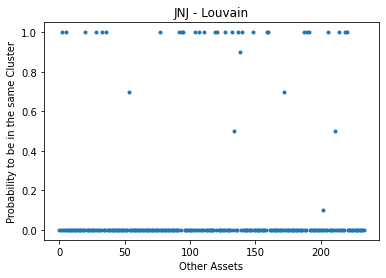

In [251]:
plt.plot(JNJ_stability_louv,'.')
plt.title('JNJ - Louvain')
plt.xlabel('Other Assets')
plt.ylabel('Probability to be in the same Cluster')


if saverfig:
    plt.figure(dpi = 300)
    plt.plot(JNJ_stability_louv,'.')
    plt.title('JNJ - Louvain')
    plt.xlabel('Other Assets')
    plt.ylabel('Probability to be in the same Cluster')
    plt.savefig('JNJ_Louvain_stability.pdf')


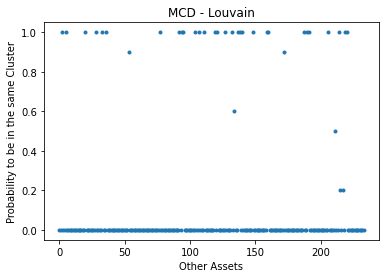

In [252]:
plt.plot(MCD_stability_louv,'.')
plt.title('MCD - Louvain')
plt.xlabel('Other Assets')
plt.ylabel('Probability to be in the same Cluster')


if saverfig:
    plt.figure(dpi = 300)
    plt.plot(MCD_stability_louv,'.')
    plt.title('MCD - Louvain')
    plt.xlabel('Other Assets')
    plt.ylabel('Probability to be in the same Cluster')
    plt.savefig('MCD_Louvain_stability.pdf')


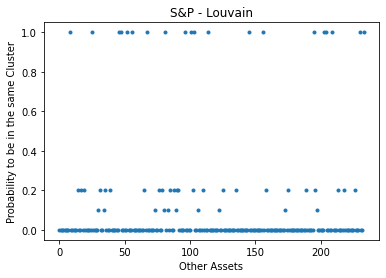

In [253]:
plt.plot(GSPC_stability_louv,'.')
plt.title('S&P - Louvain')
plt.xlabel('Other Assets')
plt.ylabel('Probability to be in the same Cluster')


if saverfig:
    plt.figure(dpi = 300)
    plt.plot(GSPC_stability_louv,'.')
    plt.title('S&P - Louvain')
    plt.xlabel('Other Assets')
    plt.ylabel('Probability to be in the same Cluster')
    plt.savefig('S_P_Louvain_stability.pdf')


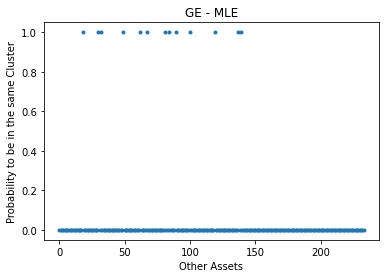

In [254]:
plt.plot(GE_stability_agg,'.')
plt.title('GE - MLE')
plt.xlabel('Other Assets')
plt.ylabel('Probability to be in the same Cluster')


if saverfig:
    plt.figure(dpi = 300)
    plt.plot(GE_stability_agg,'.')
    plt.title('GE - MLE')
    plt.xlabel('Other Assets')
    plt.ylabel('Probability to be in the same Cluster')
    plt.savefig('GE_MLE_stability.pdf')

Stability of industries; mining, banking, oil, pharmaceuticals, media, automobiles, machinery, real estate

In [118]:
for i in range(np.shape(DF_cut)[1]):
    temp_stability = stability_of_assets(DF_cut,DF_cut.columns[i],'Louvain')
    if i == 0:
        df_with_corr = pd.DataFrame(data = temp_stability, columns = [DF_cut.columns[i]])
    else:
        df_temp = pd.DataFrame(data = temp_stability, columns = [DF_cut.columns[i]])
        df_with_corr = pd.concat([df_with_corr,df_temp],axis = 1)
        
    print(i+1,' out of 234 assets analyzed')

df_corr_index = np.asarray(DF_cut.columns)
df_corr_index = np.sort(df_corr_index)
df_corr_index_louv = df_with_corr.set_index(df_corr_index)

In [194]:
for i in range(np.shape(DF_cut)[1]):
    temp_stability = stability_of_assets(DF_cut,DF_cut.columns[i],'MLE')
    if i == 0:
        df_with_corr = pd.DataFrame(data = temp_stability, columns = [DF_cut.columns[i]])
    else:
        df_temp = pd.DataFrame(data = temp_stability, columns = [DF_cut.columns[i]])
        df_with_corr = pd.concat([df_with_corr,df_temp],axis = 1)
        
    print(i+1,' out of 234 assets analyzed')

df_corr_index = np.asarray(DF_cut.columns)
df_corr_index = np.sort(df_corr_index)
df_corr_index_agg = df_with_corr.set_index(df_corr_index)

1  out of 234 assets analyzed
2  out of 234 assets analyzed
3  out of 234 assets analyzed
4  out of 234 assets analyzed
5  out of 234 assets analyzed
6  out of 234 assets analyzed
7  out of 234 assets analyzed
8  out of 234 assets analyzed
9  out of 234 assets analyzed
10  out of 234 assets analyzed
11  out of 234 assets analyzed
12  out of 234 assets analyzed
13  out of 234 assets analyzed
14  out of 234 assets analyzed
15  out of 234 assets analyzed
16  out of 234 assets analyzed
17  out of 234 assets analyzed
18  out of 234 assets analyzed
19  out of 234 assets analyzed
20  out of 234 assets analyzed
21  out of 234 assets analyzed
22  out of 234 assets analyzed
23  out of 234 assets analyzed
24  out of 234 assets analyzed
25  out of 234 assets analyzed
26  out of 234 assets analyzed
27  out of 234 assets analyzed
28  out of 234 assets analyzed
29  out of 234 assets analyzed
30  out of 234 assets analyzed
31  out of 234 assets analyzed
32  out of 234 assets analyzed
33  out of 234 as

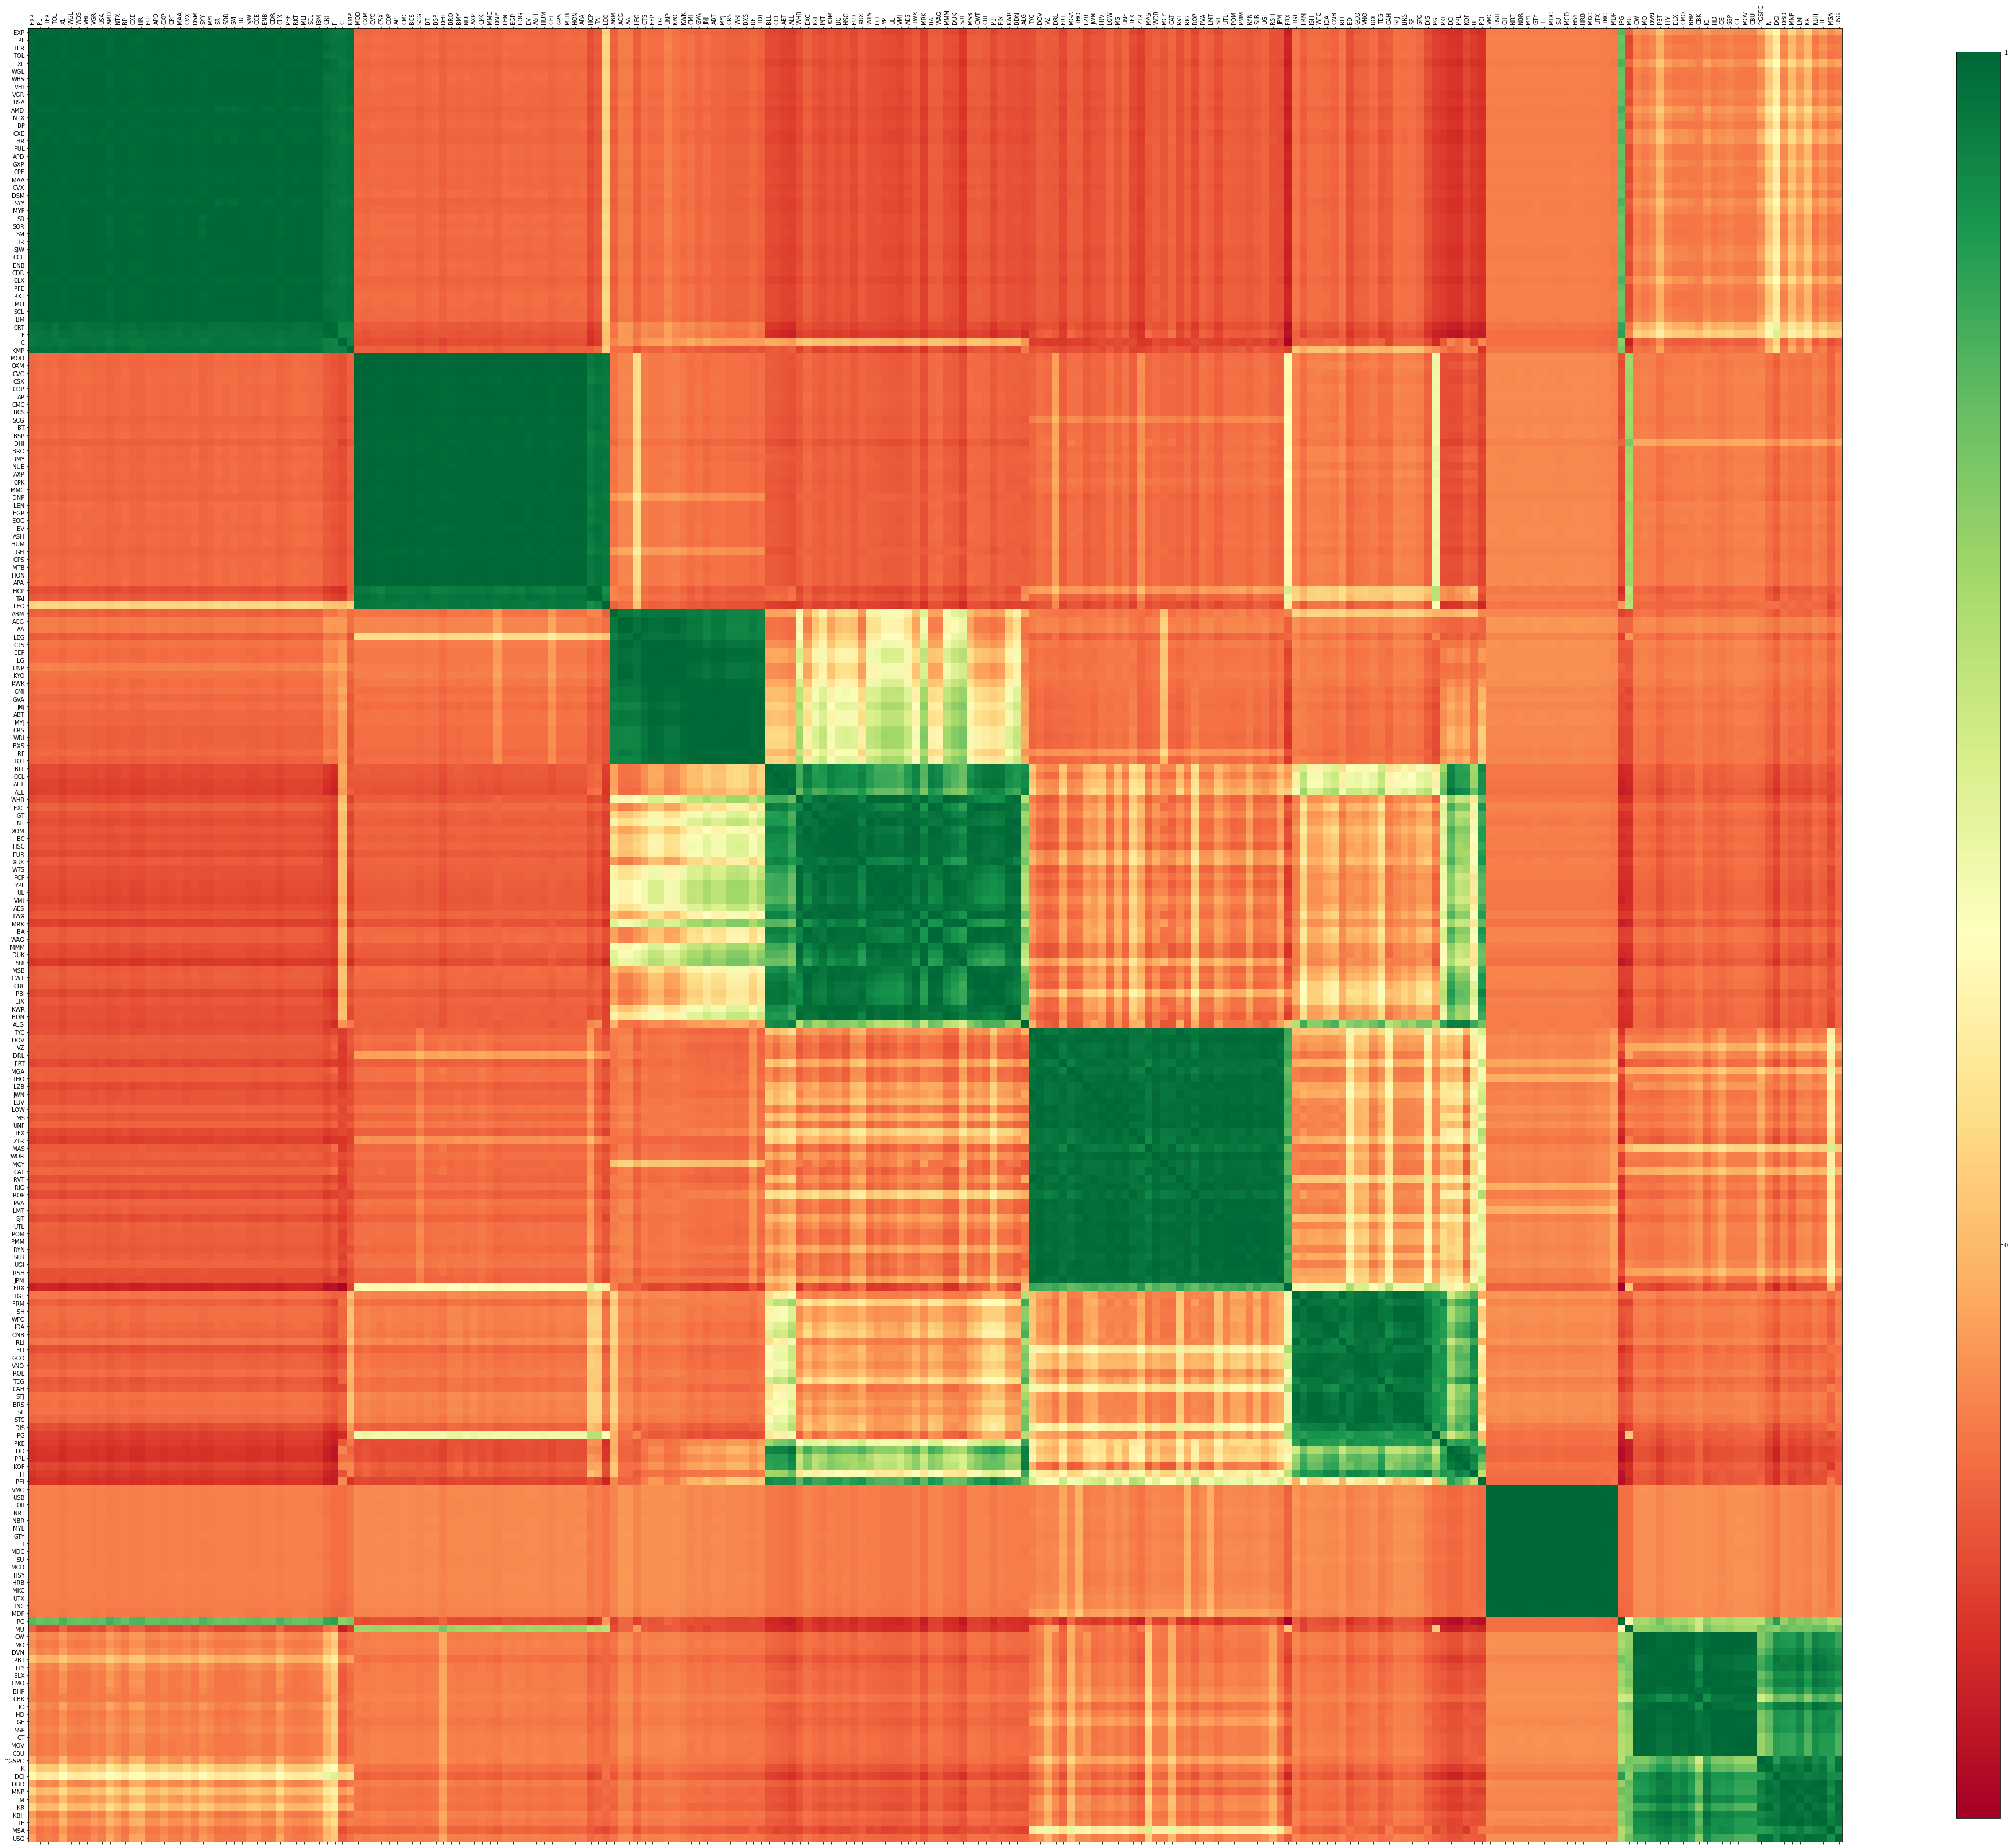

In [255]:
'''
This code snipet was taken from github:
https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
'''

cluster_th = 4
df = df_corr_index_louv
X = df
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')

columns = [df.columns.tolist()[i] for i in list(np.argsort(ind))]
df = df.reindex(columns, axis=1)

unique, counts = np.unique(ind, return_counts=True)
counts = dict(zip(unique, counts))

i = 0
j = 0
columns = []
for cluster_l1 in set(sorted(ind)):
    j += counts[cluster_l1]
    sub = df[df.columns.values[i:j]]
    if counts[cluster_l1]>cluster_th:        
        X = sub.corr().values
        d = sch.distance.pdist(X)
        L = sch.linkage(d, method='complete')
        ind = sch.fcluster(L, 0.5*d.max(), 'distance')
        col = [sub.columns.tolist()[i] for i in list((np.argsort(ind)))]
        sub = sub.reindex(col, axis=1)
    cols = sub.columns.tolist()
    columns.extend(cols)
    i = j
df = df.reindex(columns, axis=1)

plot_corr(df, 70, saverfig)

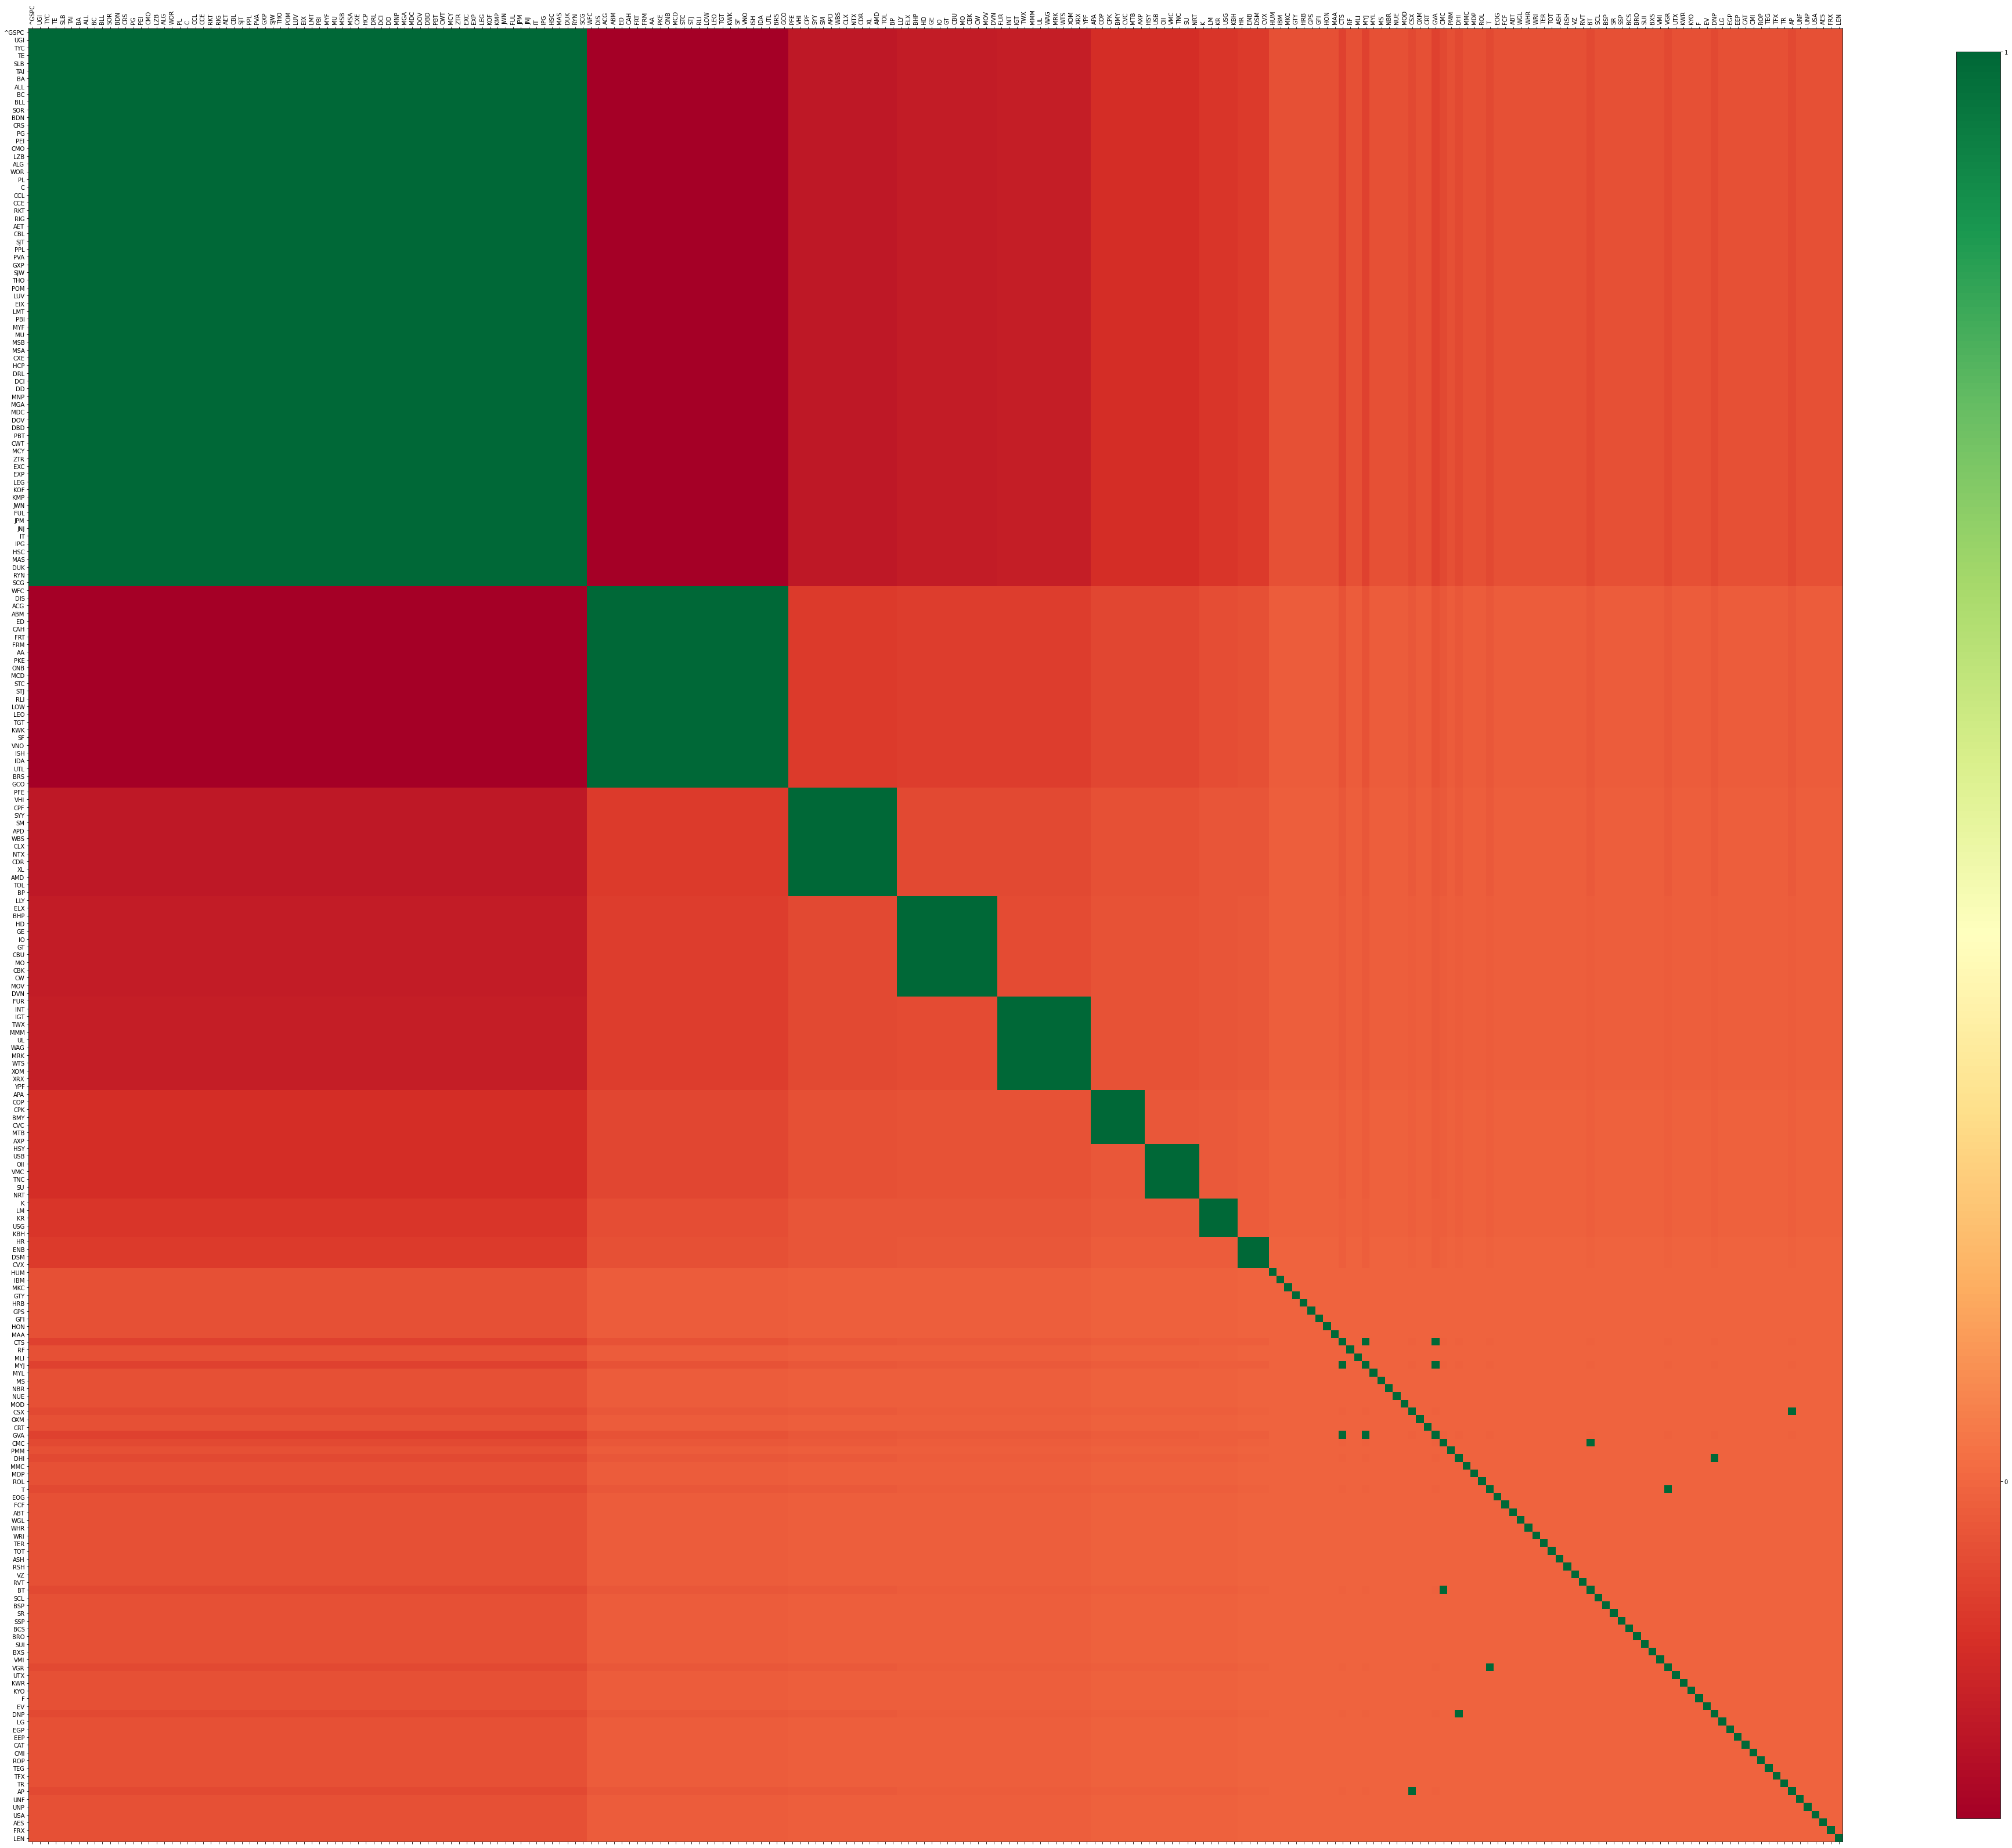

In [256]:
'''
This code snipet was taken from github:
https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
'''

cluster_th = 4
df = df_corr_index_agg
X = df
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')

columns = [df.columns.tolist()[i] for i in list(np.argsort(ind))]
df = df.reindex(columns, axis=1)

unique, counts = np.unique(ind, return_counts=True)
counts = dict(zip(unique, counts))

i = 0
j = 0
columns = []
for cluster_l1 in set(sorted(ind)):
    j += counts[cluster_l1]
    sub = df[df.columns.values[i:j]]
    if counts[cluster_l1]>cluster_th:        
        X = sub.corr().values
        d = sch.distance.pdist(X)
        L = sch.linkage(d, method='complete')
        ind = sch.fcluster(L, 0.5*d.max(), 'distance')
        col = [sub.columns.tolist()[i] for i in list((np.argsort(ind)))]
        sub = sub.reindex(col, axis=1)
    cols = sub.columns.tolist()
    columns.extend(cols)
    i = j
df = df.reindex(columns, axis=1)

plot_corr(df, 70, saverfig)